In [ ]:
# import torch

In [ ]:
# !python detect.py --weights weights/yolov5l.pt --img 416 --conf 0.4 --source 0


In [1]:
import os
import platform
import shutil
import time
from pathlib import Path

import cv2
import torch
import torch.backends.cudnn as cudnn
from numpy import random
import re
import matplotlib.pyplot as plt

from models.experimental import attempt_load
from utils.datasets import LoadStreams, LoadImages
from utils.general import (
    check_img_size, non_max_suppression, apply_classifier, scale_coords,
    xyxy2xywh, plot_one_box, strip_optimizer, set_logging, output_to_target)
from utils.torch_utils import select_device, load_classifier, time_synchronized
import pytesseract
from pytesseract import Output
from tesseract_utils import Preprocess

custom_config = r'-l eng --oem 3 --psm 6 '

class opt():
    weights = 'weights/pan_best.pt'
    source = r'C:\Users\Charan\predicts\pancard_verification-yolov5-master\cardtemplate.jpg'
    output = ''
    img_size = 416
    conf_thres = 0.4
    iou_thres = 0.5
    device = 'cpu'
    view_img = True
    save_txt = True
    classes = None
    agnostic_nms = False
    augment = False
    update = False

device = select_device(opt.device)
half = device.type != 'cpu'  # half precision only supported on CUDA
# Load model
model = attempt_load(opt.weights, map_location=device)  # load FP32 model
imgsz = check_img_size(opt.img_size, s=model.stride.max())  # check img_size
if half:
    model.half()  # to FP16
    
# Second-stage classifier
classify = False
if classify:
    modelc = load_classifier(name='resnet101', n=2)  # initialize
    modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=device)['model'])  # load weights
    modelc.to(device).eval()
    
#load inference images
save_img = True
dataset = LoadImages(opt.source, img_size=imgsz)

# Get names and colors
names = model.module.names if hasattr(model, 'module') else model.names
names[1] = 'dob'
colors = [[random.randint(0, 255) for _ in range(3)] for _ in range(len(names))]

#OCR
#try to feed this to tesseract

# Run inference
t0 = time.time()

img = torch.zeros((1, 3, opt.img_size, opt.img_size), device=opt.device)  # init img
_ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    # Inference
    t1 = time_synchronized()
    pred = model(img, augment=opt.augment)[0]
    
    # Apply NMS
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
    t2 = time_synchronized()
    
    # Apply Classifier
    if classify:
        pred = apply_classifier(pred, modelc, img, im0s)
        
    ocr_output = {'name':'', "father_name":'', 'dob':'', 'pan_number':''}  
    test_output = []
    
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        p, s, im0 = path, '', im0s
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            # Print results
            for c in det[:, -1]:
                n = (det[:, -1] == c).sum()  # detections per class
                s += '%g %ss, ' % (n, names[int(c)])  # add to string
            
            # Write results
            for *xyxy, conf, cls in reversed(det):
                label = '%s %.2f' % (names[int(cls)], conf)
                print(label)
                x1, y1, x2, y2 = xyxy
                ROT = im0[int(y1.detach().numpy()):int(y2.detach().numpy()), int(x1.detach().numpy()):int(x2.detach().numpy())]
                gray = cv2.cvtColor(ROT, cv2.COLOR_BGR2GRAY)
                ocr_result = pytesseract.image_to_string(gray, config=custom_config)
                plt.imshow(ROT)
                plt.show()
                print('TESSERACT OUTPUT ')
                print('-----------------------------------------')
                print(ocr_result)
                print('\n-----------------------------------------')
                ocr_output[names[int(cls)]] = re.sub(r'[\n\x00-\x08\x0b\x0c\x0e-\x1f\x7f-\xff]', '', ocr_result)
                test_output.append(ocr_result)
        # Print time (inference + NMS)
#         print('%sDone. (%.3fs)' % (s, t2 - t1))

c:\Users\Charan\Anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


Fusing layers... 
image 1/1 C:\Users\Charan\predicts\pancard_verification-yolov5-master\cardtemplate.jpg: 

AttributeError: 'Hardswish' object has no attribute 'inplace'

In [2]:
ocr_output

{'name': 'SHEKHAR',
 'father_name': 'JAYARAMA',
 'dob': '27/01/1995',
 'pan_number': 'HESPS0801G',
 'sign': 'Shae'}

image 1/1 /home/neo/Desktop/pan1.jpg: 

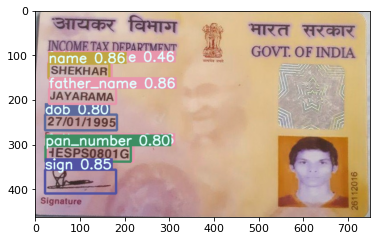

288x416 3 father_names, 1 names, 1 signs, 1 dobs, 1 pan_numbers, 3 father_names, 3 father_names, Done. (0.121s)


In [3]:
# Run inference
t0 = time.time()

img = torch.zeros((1, 3, opt.img_size, opt.img_size), device=opt.device)  # init img
_ = model(img.half() if half else img) if device.type != 'cpu' else None  # run once

for path, img, im0s, vid_cap in dataset:
    img = torch.from_numpy(img).to(device)
    img = img.half() if half else img.float()  # uint8 to fp16/32
    img /= 255.0  # 0 - 255 to 0.0 - 1.0
    if img.ndimension() == 3:
        img = img.unsqueeze(0)
        
    # Inference
    t1 = time_synchronized()
    pred = model(img, augment=opt.augment)[0]
    
    # Apply NMS
    pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
    t2 = time_synchronized()
    
    # Apply Classifier
    if classify:
        pred = apply_classifier(pred, modelc, img, im0s)
        
    # Process detections
    for i, det in enumerate(pred):  # detections per image
        p, s, im0 = path, '', im0s
        save_path = str(Path(opt.output) / Path(p).name)
        txt_path = str(Path(opt.output) / Path(p).stem) + ('_%g' % dataset.frame if dataset.mode == 'video' else '')
        s += '%gx%g ' % img.shape[2:]  # print string
        gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
        if det is not None and len(det):
            # Rescale boxes from img_size to im0 size
            det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()
            # Print results
            for c in det[:, -1]:
                n = (det[:, -1] == c).sum()  # detections per class
                s += '%g %ss, ' % (n, names[int(c)])  # add to string
           
            # Write results
            for *xyxy, conf, cls in reversed(det):
                if opt.save_txt:  # Write to file
                    xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                    with open(txt_path + '.txt', 'a') as f:
                        f.write(('%g ' * 5 + '\n') % (cls, *xywh))  # label format
                if save_img or view_img:  # Add bbox to image
                    label = '%s %.2f' % (names[int(cls)], conf)
                    plot_one_box(xyxy, im0, label=label, color=colors[int(cls)], line_thickness=3)
#             cv2.imwrite('inference/output/output.jpg', im0)
            plt.imshow(im0)
            plt.show()
        # Print time (inference + NMS)
        print('%sDone. (%.3fs)' % (s, t2 - t1))

In [ ]:
# def output_to_target(output, width, height):
#     # Convert model output to target format [batch_id, class_id, x, y, w, h, conf]
#     if isinstance(output, torch.Tensor):
#         print('test')
#         output = output.cpu().detach().numpy()
#     else:
#         print('fail')
#     targets = []
#     for i, o in enumerate(output):
#         if o is not None:
#             for pred in o:
#                 box = pred[:4]
#                 w = (box[2] - box[0]) / width
#                 h = (box[3] - box[1]) / height
#                 x = box[0] / width + w / 2
#                 y = box[1] / height + h / 2
#                 conf = pred[4]
#                 cls = int(pred[5])

#                 targets.append([i, cls, x, y, w, h, conf])

#     return np.array(targets)
